# Predicting sale Price of Bulldozers using Machine Learning

The goal is to preddict the sale price of Bulldozers

## (1)Problem

> Given the characteristic of a Bulldozer and previous examples how much can we preict the Sales Price of Bulldozers

## (2) Data

> Data available from  https://www.kaggle.com/c/bluebook-for-bulldozers/data 

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## (3) Evaluation

> The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

**NOTE** The goal is to minimize the error, and here it will be minimizing RMSLE

## (4) Features

> The features is also availabe from the above dataset link



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
# Import training and validation set
df = pd.read_csv("data/TrainAndValid.csv",low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

### Parsing Dates

In time series problems, we want to utilize the date and time columns at maximum

We can use 'parse date' available in pandas, because in our df salesdate is of type object

In [5]:
df = pd.read_csv("data/TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

In [6]:
df.saledate[:4]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
Name: saledate, dtype: datetime64[ns]

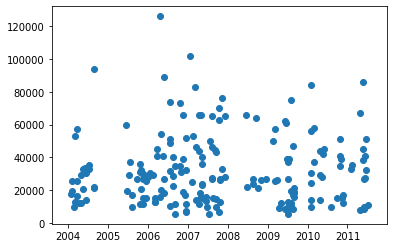

In [7]:
fig ,ax = plt.subplots()
ax.scatter(df["saledate"][:200],df["SalePrice"][:200]);

In [8]:
# Sort df by date , so that it will be easy and relavant for a time series problem
df.sort_values(by=["saledate"],inplace=True,ascending=True)
df.saledate[:20]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [9]:
# Making a copy of the data frame
df_temp = df.copy()

### Adding date time parameters to `saledate`

In [10]:
print(df_temp[:1].saledate.dt.year) , print(df_temp[:1].saledate.dt.day)

205615    1989
Name: saledate, dtype: int64
205615    17
Name: saledate, dtype: int64


(None, None)

In [11]:
df_temp["saleYear"] =df_temp.saledate.dt.year
df_temp["saleMonth"] =df_temp.saledate.dt.month
df_temp["saleDay"]= df_temp.saledate.dt.day
df_temp["saleDayOfWeek"] =df_temp.saledate.dt.dayofweek
df_temp["saleYearDayOfYear"] =df_temp.saledate.dt.dayofyear
df_temp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleYearDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


In [12]:
# we will drop original sale date column, as we have the date spread across columns
df_temp.drop("saledate",axis=1,inplace=True)

### (5) Modelling

#### Before modelling, we will deal with missing values and data that is not in numeric format

In [13]:
for label,content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] =  content.astype("category").cat.as_ordered()

In [14]:
# we have converted all the string columns to categories
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [15]:
# As we have converted the string columns to categories, we now have 'cat' 
# to access the columns, each string values will be assigned a code now, by 
# which we can access them
df_temp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [16]:
### Save the processed data to a csv file
df_temp.to_csv("data/processed.csv",index=False)

In [17]:
# Numeric columns havig null values
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [18]:
## Fill those numeric column with the median
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_temp[label+"_is_missing"] = pd.isnull(content)
            df_temp[label]=content.fillna(content.median())

In [19]:
## Recheck for null
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [20]:
df_temp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [21]:
## Fill categorical variables
for label,content in df_temp.items():
    if pd.api.types.is_categorical(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [22]:
## tun categorical variable into numbers and fill missing
for label,content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_temp[label+"_is_missing"] = pd.isnull(content)
        df_temp[label] = pd.Categorical(content).codes + 1

In [23]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 81.1 MB


In [24]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [25]:
df_temp.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [26]:
len(df_temp)

412698

In [28]:

%%time
## Get the time ued to train the model
model = RandomForestRegressor(n_jobs = -1,random_state=2)

model.fit(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"])


Wall time: 11min 59s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [30]:
model.score(df_temp.drop("SalePrice",axis=1),df_temp["SalePrice"])

0.9875855808146402

In [31]:
## The above model score is not relavant as our train and scoring set are the same
## We will now split the data based on sale year and fit model again

In [32]:
df_temp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [34]:
df_val = df_temp[df_temp.saleYear == 2012]
df_train = df_temp[df_temp.saleYear != 2012]

In [36]:
# Split in X,Y
X_train, Y_train = df_train.drop("SalePrice",axis=1),df_train.SalePrice
X_valid,Y_valid = df_val.drop("SalePrice",axis=1),df_val.SalePrice

X_train.shape,Y_train.shape,X_valid.shape,Y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [41]:
## Evaluation Function
from sklearn.metrics import mean_squared_log_error,mean_absolute_error, r2_score

def rmsle(Y_test,Y_preds):
    """
    Some Doc string
    """
    return np.sqrt(mean_squared_log_error(Y_test,Y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE" : mean_absolute_error(Y_train,train_preds),
              "Valid MAE" : mean_absolute_error(Y_valid,val_preds),
              "Training RMSLE" : rmsle(Y_train,train_preds),
              "Valid RMSLE" : rmsle(Y_valid,val_preds),
               "Training R^2" :r2_score(Y_train,train_preds),
                "Valid R^2" : r2_score(Y_valid,val_preds)}
    return scores



### test our model on a subset of data to tune our hyperparameters

In [45]:
model = RandomForestRegressor(n_jobs = -1,random_state=2,max_samples=10000)


In [46]:
%%time
model.fit(X_train,Y_train)

Wall time: 30.4 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [47]:
show_scores(model)

{'Training MAE': 5567.383629442193,
 'Valid MAE': 7184.613960943576,
 'Training RMSLE': 0.25799823586969256,
 'Valid RMSLE': 0.2939149999855614,
 'Training R^2': 0.8602028597913625,
 'Valid R^2': 0.8332175353133906}

### Hyperparameter Tuning with RandomizedSearchCV

In [57]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators" : np.arange(10,100,10),
           "max_depth" : [None,3,5,10],
           "min_samples_split" : np.arange(2,20,2),
           "min_samples_leaf" : np.arange(1,20,2),
           "max_features" : [0.5,1,"sqrt","auto"],
           "max_samples" : [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=2),
                                                    param_distributions=rf_grid,
                                                   n_iter=2,
                                                   cv=5,
                                                   verbose=True)

rs_model.fit(X_train,Y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


Wall time: 1min 30s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [58]:
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 16,
 'min_samples_leaf': 13,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': None}

In [60]:
# Evalution of this model
show_scores(rs_model)

{'Training MAE': 8625.048576333033,
 'Valid MAE': 10190.823864687223,
 'Training RMSLE': 0.3777114264045721,
 'Valid RMSLE': 0.40603676233591235,
 'Training R^2': 0.6975613550429185,
 'Valid R^2': 0.6929133411883917}

In [63]:
## training model using best hyperpameters found using n_iter=100

final_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features = 0.5,
                                   n_jobs=-1,
                                   max_samples=None,random_state=2)

final_model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [64]:
show_scores(final_model)

{'Training MAE': 2953.041028873544,
 'Valid MAE': 5920.403635700959,
 'Training RMSLE': 0.14462004816713497,
 'Valid RMSLE': 0.2455521946273049,
 'Training R^2': 0.9589793941415604,
 'Valid R^2': 0.8827859377685051}

In [90]:
## Make predicitions on the test data
df_test = pd.read_csv("data/Test.csv",parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [67]:
# Predictions on test data
test_pred =final_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

In [79]:
df_test.saledate

0       2012-05-03
1       2012-05-10
2       2012-05-10
3       2012-05-10
4       2012-05-10
           ...    
12452   2012-10-24
12453   2012-10-24
12454   2012-10-24
12455   2012-10-24
12456   2012-09-19
Name: saledate, Length: 12457, dtype: datetime64[ns]

In [91]:
## Data proessing on the test data similiar to what we did in train data
def preprocessdata(data):
    """
    Preprocess data
    """    
    data["saleYear"] = data.saledate.dt.year
    data["saleMonth"] = data.saledate.dt.month
    data["saleDay"]= data.saledate.dt.day
    data["saleDayOfWeek"] = data.saledate.dt.dayofweek
    data["saleYearDayOfYear"] = data.saledate.dt.dayofyear
    
    data.drop("saledate",axis=1,inplace=True)
    
    # Fill numeric rows with median
    for label,content in data.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                data[label+"_is_missing"] = pd.isnull(content)
                data[label]=content.fillna(content.median())
    
            #Fill categorical missing data and turn categories to numeric 
        if not pd.api.types.is_numeric_dtype(content):
            data[label+"_is_missing"] = pd.isnull(content)
            data[label] = pd.Categorical(content).codes+1

    return data
            
    

In [92]:
new_test = preprocessdata(df_test)

In [93]:
new_test.shape

(12457, 101)

In [94]:
set(X_train.columns)  - set(df_test.columns)

{'auctioneerID_is_missing'}

In [95]:
# Manuall add the column to df_test
df_test["auctioneerID_is_missing"] = False

In [96]:
new_test.shape

(12457, 102)

In [97]:
final_preds = final_model.predict(df_test)

In [98]:
len(final_preds)

12457

In [99]:
# Format preds for Submission
sub_df = pd.DataFrame()
sub_df["SalesID"] = df_test["SalesID"]
sub_df["SalesPrice"] = final_preds
sub_df

,SalesID,SalesPrice
0,1227829,19565.879442
1,1227844,17899.852262
2,1227847,49980.122177
3,1227848,63150.530279
4,1227863,44404.542047
...,...,...
12452,6643171,47600.971550
12453,6643173,20096.399108
12454,6643184,17972.967068
12455,6643186,24403.888901


In [100]:
sub_df.to_csv("data/submission.csv",index=False)

### Feature Importance

Feature Importance seeks to figure which attributes of data are most important

In [102]:
# Find feature importance
final_model.feature_importances_

array([3.40491361e-02, 1.52402631e-02, 4.43034060e-02, 1.85963334e-03,
       3.33283206e-03, 1.95988825e-01, 3.15742690e-03, 1.02091364e-03,
       4.59515016e-02, 4.94992374e-02, 6.71772145e-02, 4.62252493e-03,
       2.28219336e-02, 1.35152391e-01, 4.53127003e-02, 5.97772379e-03,
       2.43615657e-03, 4.28653643e-03, 2.57249747e-03, 7.30092623e-02,
       7.05784451e-04, 7.27566472e-04, 1.06816317e-03, 1.96129613e-04,
       9.71616593e-04, 1.95857281e-05, 4.90260099e-04, 4.62197435e-03,
       2.27499346e-03, 5.63084264e-04, 5.22980607e-03, 2.69616236e-03,
       2.93684827e-03, 3.68458424e-03, 2.27093479e-03, 1.12901926e-02,
       9.56453992e-04, 1.03558143e-02, 2.09367667e-03, 4.52035373e-04,
       1.43333508e-03, 1.01392991e-03, 2.98340654e-03, 5.83130800e-04,
       5.70384509e-04, 3.14888893e-04, 4.06404536e-04, 1.94950017e-03,
       1.49844623e-03, 1.49936798e-04, 1.76097777e-04, 7.26834874e-02,
       3.84470489e-03, 5.72606999e-03, 2.92673015e-03, 9.83806924e-03,
      

In [103]:
len(final_model.feature_importances_)

102

In [112]:
def plot_features(columns,importance):
    df = (pd.DataFrame({"feature":columns,
                        "feature_importances": importance})
         .sort_values("feature_importances",ascending=False)
         .reset_index(drop=True))
    
    fig,ax = plt.subplots()
    ax.barh(df["feature"][:20],df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

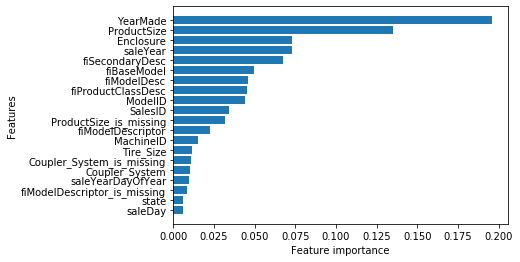

In [113]:
plot_features(X_train.columns,final_model.feature_importances_)